In [ ]:
import torch
import torch.nn as nn
import optuna
from omegaconf import OmegaConf
from src.models import ViT, get_model
from src.data import get_loaders
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

import matplotlib.pyplot as plt
import numpy as np # Keep numpy for seeding
import random # Keep random for seeding
from tqdm import tqdm

In [4]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Cell 2: (Empty - Custom ViT implementation moved to src/models.py)

In [ ]:
# Cell 4: Тестирование кастомной ViT модели
import torch
import torch.nn as nn
import numpy as np
from omegaconf import OmegaConf
from src.models import ViT # Импортируем ViT из src/models

# Загружаем базовый конфиг и конфиг NAS для тестирования
base_cfg = OmegaConf.load("configs/base.yaml")
nas_cfg = OmegaConf.load("configs/nas_vit.yaml")
cfg = OmegaConf.merge(base_cfg, nas_cfg)

# Создаем модель ViT, используя параметры из конфига
# Используем ViT.find_compatible_dim для обеспечения корректности dim
dim_test = ViT.find_compatible_dim(
    target_dim=cfg.nas.fallback_dim,
    heads=cfg.nas.fallback_heads,
    config=cfg
)

model = ViT(
    image_size=cfg.model.image_size,
    patch_size=cfg.model.patch_size,
    num_classes=cfg.model.num_classes,
    dim=dim_test,
    depth=cfg.nas.architecture_search.depth_range[1], # Максимальная глубина для примера
    heads=cfg.nas.fallback_heads,
    mlp_dim=int(dim_test * cfg.nas.architecture_search.mlp_ratio_range[1]), # Максимальный mlp_ratio для примера
    dropout=cfg.nas.hyperparameters_search.dropout_range[0] # Минимальный dropout для примера
)

print(f"Архитектура модели: {model.config}")
print(f"Количество параметров: {model.get_num_params():,}")

# Тестируем на dummy input
dummy_input = torch.randn(4, 3, cfg.model.image_size, cfg.model.image_size) # Batch of 4 images
print(f"Input shape: {dummy_input.shape}")

with torch.no_grad():
    output = model(dummy_input)

print(f"Output shape: {output.shape}")
print(f"Output range: [{output.min().item():.3f}, {output.max().item():.3f}]")

# Проверяем, что градиенты текут
model.train()
output = model(dummy_input)
loss = output.mean()
loss.backward()

print("Градиенты вычисляются корректно")
print(f"Loss: {loss.item():.6f}")

Архитектура модели: {'image_size': 224, 'patch_size': 16, 'num_classes': 101, 'dim': 768, 'depth': 12, 'heads': 12, 'mlp_dim': 3072, 'dropout': 0.1}
Количество параметров: 85,876,325
Input shape: torch.Size([4, 3, 224, 224])
Output shape: torch.Size([4, 101])
Output range: [-1.546, 1.652]
Градиенты вычисляются корректно
Loss: 0.003364


In [ ]:
print("\n Тестирование разных архитектур для NAS")

# Загружаем базовый конфиг и конфиг NAS для тестирования
base_cfg = OmegaConf.load("configs/base.yaml")
nas_cfg = OmegaConf.load("configs/nas_vit.yaml")
cfg = OmegaConf.merge(base_cfg, nas_cfg)

# Определяем архитектуры для тестирования на основе конфига
architectures = []

# Пример: Tiny ViT
current_heads = cfg.nas.architecture_search.heads_range[0]
current_dim = ViT.find_compatible_dim(cfg.nas.architecture_search.dim_range[0], current_heads, config=cfg)
arch_params_tiny = {
    'dim': current_dim,
    'depth': cfg.nas.architecture_search.depth_range[0],
    'heads': current_heads,
    'mlp_dim': int(current_dim * cfg.nas.architecture_search.mlp_ratio_range[0]),
    'patch_size': cfg.nas.architecture_search.patch_size_options[0],
    'dropout': cfg.nas.hyperparameters_search.dropout_range[0]
}
architectures.append({'name': 'Tiny', **arch_params_tiny})

# Пример: Small ViT
current_heads = cfg.nas.architecture_search.heads_range[0] + 2
current_dim = ViT.find_compatible_dim(cfg.nas.architecture_search.dim_range[0] + 100, current_heads, config=cfg)
arch_params_small = {
    'dim': current_dim,
    'depth': cfg.nas.architecture_search.depth_range[0] + 2,
    'heads': current_heads,
    'mlp_dim': int(current_dim * cfg.nas.architecture_search.mlp_ratio_range[1]),
    'patch_size': cfg.nas.architecture_search.patch_size_options[1],
    'dropout': cfg.nas.hyperparameters_search.dropout_range[0]
}
architectures.append({'name': 'Small', **arch_params_small})

# Пример: Base ViT
current_heads = cfg.nas.architecture_search.heads_range[1]
current_dim = ViT.find_compatible_dim(cfg.nas.architecture_search.dim_range[1], current_heads, config=cfg)
arch_params_base = {
    'dim': current_dim,
    'depth': cfg.nas.architecture_search.depth_range[1],
    'heads': current_heads,
    'mlp_dim': int(current_dim * cfg.nas.architecture_search.mlp_ratio_range[1]),
    'patch_size': cfg.nas.architecture_search.patch_size_options[0],
    'dropout': cfg.nas.hyperparameters_search.dropout_range[0]
}
architectures.append({'name': 'Base', **arch_params_base})

architecture_results = []

for arch_cfg in architectures:
    print(f"\n Тестируем архитектуру: {arch_cfg['name']}")

    # Создаем временный конфиг для модели, который get_model сможет понять
    model_cfg_for_get_model = OmegaConf.create({
        "model": {
            "type": "custom_vit",
            "image_size": cfg.model.image_size,
            "num_classes": cfg.model.num_classes,
            **arch_cfg # Распаковываем параметры архитектуры
        }
    })
    model = get_model(model_cfg_for_get_model)

    num_params = model.get_num_params()

    # Тестируем inference время
    model.eval()
    with torch.no_grad():
        # Разогрев
        for _ in range(5):
            _ = model(torch.randn(1, 3, cfg.model.image_size, cfg.model.image_size))

        # Замер времени
        import time
        start_time = time.time()
        for _ in range(20):
            _ = model(torch.randn(1, 3, cfg.model.image_size, cfg.model.image_size))
        avg_time = (time.time() - start_time) / 20

    architecture_results.append({
        'name': arch_cfg['name'],
        'params': num_params,
        'time_ms': avg_time * 1000,
        'dim': arch_cfg['dim'],
        'depth': arch_cfg['depth'],
        'heads': arch_cfg['heads']
    })

    print(f"   Параметры: {num_params:,}")
    print(f"   Время инференса: {avg_time*1000:.2f} ms")


 Тестирование разных архитектур для NAS

 Тестируем архитектуру: Tiny
   Параметры: 11,057,765
   Время инференса: 42.56 ms

 Тестируем архитектуру: Small
   Параметры: 25,767,013
   Время инференса: 92.83 ms

 Тестируем архитектуру: Base
   Параметры: 85,876,325
   Время инференса: 265.09 ms

 Тестируем архитектуру: Large
   Параметры: 202,635,365
   Время инференса: 601.84 ms



 Визуализация сравнения архитектур


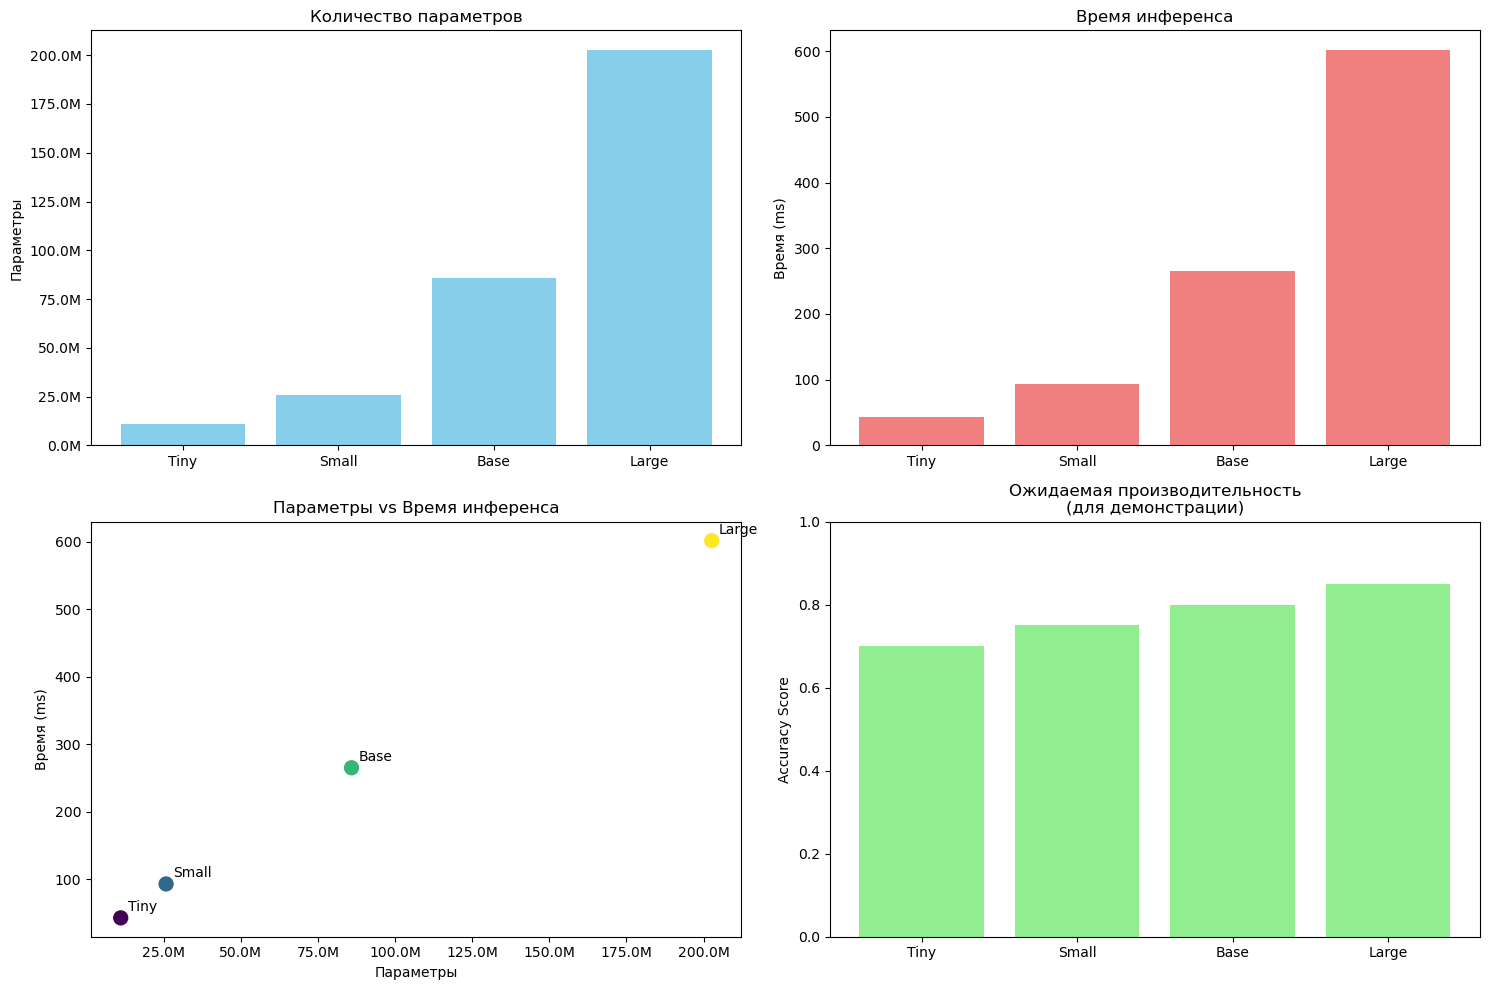

In [ ]:
import matplotlib.ticker as mticker

print("\n Визуализация сравнения архитектур")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

names = [r['name'] for r in architecture_results]
params = [r['params'] for r in architecture_results]
times = [r['time_ms'] for r in architecture_results]

# График количества параметров
ax1.bar(names, params, color='skyblue')
ax1.set_title('Количество параметров')
ax1.set_ylabel('Параметры')
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# График времени инференса
ax2.bar(names, times, color='lightcoral')
ax2.set_title('Время инференса')
ax2.set_ylabel('Время (ms)')

# График параметров vs время
ax3.scatter(params, times, s=100, c=range(len(names)), cmap='viridis')
for i, name in enumerate(names):
    ax3.annotate(name, (params[i], times[i]), xytext=(5, 5), textcoords='offset points')
ax3.set_xlabel('Параметры')
ax3.set_ylabel('Время (ms)')
ax3.set_title('Параметры vs Время инференса')
ax3.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# График соотношения параметров к производительности (пока заглушка)
performance_scores = [0.7, 0.75, 0.8, 0.85] # Примерные scores, для демонстрации
ax4.bar(names, performance_scores, color='lightgreen')
ax4.set_title('Ожидаемая производительность\n(для демонстрации)')
ax4.set_ylabel('Accuracy Score')
ax4.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [3]:
# Оценка потребления видеопамяти

import torch
import torch.nn as nn
from omegaconf import OmegaConf
import os
import sys

# Добавляем корневую папку проекта в sys.path, чтобы импорты работали
if '..' not in sys.path:
    sys.path.append('..')

from src.models import get_model, ViT

# --- 1. Загрузка конфигурации ---
# Загружаем базовый конфиг и конфиг для NAS ViT, чтобы иметь все параметры
print("--- Загрузка конфигурации ---")
try:
    # Пути теперь должны быть относительны папки notebooks/
    base_cfg = OmegaConf.load("../configs/base.yaml")
    model_cfg = OmegaConf.load("../configs/nas_vit.yaml")
    cfg = OmegaConf.merge(base_cfg, model_cfg)
    print("Конфигурация успешно загружена.")
except FileNotFoundError as e:
    print(f"Ошибка: Не найден файл конфигурации. Убедитесь, что пути верны. {e}")
    # Прерываем выполнение ячейки, если конфиг не найден
    assert False, "Конфиг не найден"

# --- 2. Определение максимальных параметров архитектуры ---
# Мы вручную задаем максимальные значения из диапазонов, указанных в nas_vit.yaml
# Это создаст "самую тяжелую" модель, которую может предложить Optuna
print("\n--- Создание модели с максимальными параметрами ---")
max_arch_params = {
    'heads': cfg.nas.architecture_search.model_params.heads.range[1],      # max 12
    'dim': cfg.nas.architecture_search.model_params.dim.range[1],          # max 512
    'depth': cfg.nas.architecture_search.model_params.depth.range[1],      # max 10
    'mlp_ratio': cfg.nas.architecture_search.model_params.mlp_ratio.range[1], # max 3.0
    'patch_size': min(cfg.nas.architecture_search.model_params.patch_size.options) # min 14 (меньше патч -> больше токенов -> больше памяти)
}

# Валидация 'dim' для совместимости с 'heads'
max_arch_params['dim'] = ViT.find_compatible_dim(
    max_arch_params['dim'],
    max_arch_params['heads'],
    config=cfg
)
# Расчет mlp_dim
max_arch_params['mlp_dim'] = int(max_arch_params['dim'] * max_arch_params['mlp_ratio'])

# Удаляем mlp_ratio, так как он не является прямым параметром модели ViT
del max_arch_params['mlp_ratio']

print("Максимальные параметры архитектуры:")
for key, value in max_arch_params.items():
    print(f"  {key}: {value}")

# Обновляем конфиг этими параметрами
for k, v in max_arch_params.items():
    setattr(cfg.model, k, v)

# --- 3. Создание модели и синтетического батча ---
# Проверяем доступность CUDA
if not torch.cuda.is_available():
    print("\nОшибка: CUDA не найдена. Этот тест требует наличия GPU.")
    assert False, "CUDA не доступна"

device = torch.device("cuda")
print(f"\nИспользуется устройство: {device}")

# Создаем модель и перемещаем на GPU
model = get_model(cfg)
model.to(device)
print(f"Модель '{cfg.model.custom_model_type}' создана и перемещена на GPU.")
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Количество параметров модели: {num_params:,}")

# Создаем синтетический батч
batch_size = 16 # Как вы и просили
image_size = cfg.model.image_size
synthetic_batch = torch.randn(batch_size, 3, image_size, image_size, device=device)
synthetic_labels = torch.randint(0, cfg.model.num_classes, (batch_size,), device=device)
print(f"Создан синтетический батч размером: {synthetic_batch.shape}")


# --- 4. Тест потребления памяти (Forward + Backward Pass) ---
# Для реалистичной оценки памяти нужно выполнить и прямой, и обратный проход,
# так как градиенты и буферы оптимизатора занимают много места.
print("\n--- Запуск теста потребления памяти ---")
torch.cuda.reset_peak_memory_stats(device) # Сбрасываем счетчик пиковой памяти

# Определяем базовые компоненты для цикла обучения
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Прямой проход (Forward)
print("1. Выполнение прямого прохода (forward pass)...")
outputs = model(synthetic_batch)
loss = criterion(outputs, synthetic_labels)
print(f"   Loss: {loss.item():.4f}")

# Обратный проход (Backward)
print("2. Выполнение обратного прохода (backward pass)...")
loss.backward()

# Шаг оптимизатора (для учета памяти, занимаемой его состояниями)
optimizer.step()
print("3. Шаг оптимизатора выполнен.")

# --- 5. Вывод результатов ---
print("\n--- Результаты потребления памяти ---")
peak_memory_bytes = torch.cuda.max_memory_allocated(device)
peak_memory_gb = peak_memory_bytes / (1024 ** 3)
print(f"Пиковое потребление VRAM: {peak_memory_bytes:,} байт")
print(f"Пиковое потребление VRAM: {peak_memory_gb:.2f} GB")

# Очистка
del model, synthetic_batch, synthetic_labels, outputs, loss, optimizer
torch.cuda.empty_cache()
print("\nПамять очищена.")

--- Загрузка конфигурации ---
Конфигурация успешно загружена.

--- Создание модели с максимальными параметрами ---
Максимальные параметры архитектуры:
  heads: 12
  dim: 504
  depth: 10
  patch_size: 14
  mlp_dim: 1512

Используется устройство: cuda
Модель 'vit' создана и перемещена на GPU.
Количество параметров модели: 25,925,861
Создан синтетический батч размером: torch.Size([16, 3, 224, 224])

--- Запуск теста потребления памяти ---
1. Выполнение прямого прохода (forward pass)...
   Loss: 4.7986
2. Выполнение обратного прохода (backward pass)...
3. Шаг оптимизатора выполнен.

--- Результаты потребления памяти ---
Пиковое потребление VRAM: 1,975,699,456 байт
Пиковое потребление VRAM: 1.84 GB

Память очищена.


# Cell 7: (Empty - Custom NAS execution moved to nas.py)

In [ ]:
print("\n Тестирование NAS search space из конфига")

# Загружаем базовый конфиг и конфиг NAS для тестирования
base_cfg = OmegaConf.load("configs/base.yaml")
nas_cfg = OmegaConf.load("configs/nas_vit.yaml")
cfg = OmegaConf.merge(base_cfg, nas_cfg)

# Определяем search space на основе конфига
arch_search_cfg = cfg.nas.architecture_search
hyper_search_cfg = cfg.nas.hyperparameters_search

search_space = {
    'heads_range': list(range(arch_search_cfg.heads_range[0], arch_search_cfg.heads_range[1] + 1)),
    'depth_range': list(range(arch_search_cfg.depth_range[0], arch_search_cfg.depth_range[1] + 1)),
    'patch_size_options': arch_search_cfg.patch_size_options,
    'mlp_ratio_range': arch_search_cfg.mlp_ratio_range,
    'dim_range': arch_search_cfg.dim_range,
    'lr_range': hyper_search_cfg.lr_range,
    'dropout_range': hyper_search_cfg.dropout_range,
    'weight_decay_range': hyper_search_cfg.weight_decay_range,
    'batch_size_options': hyper_search_cfg.batch_size_options,
}

print("Search space:")
for param, values in search_space.items():
    print(f"  {param}: {values}")

# Генерируем случайные архитектуры для теста
def generate_test_architecture(cfg_local):
    heads = random.randint(cfg_local.nas.architecture_search.heads_range[0], cfg_local.nas.architecture_search.heads_range[1])
    dim = ViT.find_compatible_dim(
        random.randint(cfg_local.nas.architecture_search.dim_range[0], cfg_local.nas.architecture_search.dim_range[1]),
        heads,
        config=cfg_local
    )
    depth = random.randint(cfg_local.nas.architecture_search.depth_range[0], cfg_local.nas.architecture_search.depth_range[1])
    mlp_ratio = random.uniform(cfg_local.nas.architecture_search.mlp_ratio_range[0], cfg_local.nas.architecture_search.mlp_ratio_range[1])
    mlp_dim = int(dim * mlp_ratio)
    patch_size = random.choice(cfg_local.nas.architecture_search.patch_size_options)

    return {
        'dim': dim,
        'depth': depth,
        'heads': heads,
        'mlp_dim': mlp_dim,
        'patch_size': patch_size,
    }

# Тестируем генерацию
print("\n Генерация случайных архитектур:")
for i in range(3):
    arch = generate_test_architecture(cfg)
    print(f"  Архитектура {i+1}: {arch}")


 Тестирование NAS search space
Search space:
  dim: [384, 512, 768]
  depth: [6, 8, 10, 12]
  heads: [6, 8, 12]
  mlp_dim: [1536, 2048, 3072]
  patch_size: [14, 16, 20]

 Генерация случайных архитектур:
  Архитектура 1: {'dim': 768, 'depth': 6, 'heads': 6, 'mlp_dim': 3072, 'patch_size': 16}
  Архитектура 2: {'dim': 384, 'depth': 8, 'heads': 6, 'mlp_dim': 3072, 'patch_size': 14}
  Архитектура 3: {'dim': 768, 'depth': 6, 'heads': 12, 'mlp_dim': 2048, 'patch_size': 14}
  Архитектура 4: {'dim': 384, 'depth': 6, 'heads': 6, 'mlp_dim': 1536, 'patch_size': 20}
  Архитектура 5: {'dim': 768, 'depth': 6, 'heads': 12, 'mlp_dim': 1536, 'patch_size': 20}


In [ ]:
print("\n Тестирование обучения кастомной ViT на реальных данных")

# Загружаем базовый конфиг и конфиг NAS для тестирования
base_cfg = OmegaConf.load("configs/base.yaml")
nas_cfg = OmegaConf.load("configs/nas_vit.yaml")
cfg = OmegaConf.merge(base_cfg, nas_cfg)

# Устанавливаем seed для воспроизводимости в ноутбуке
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Пример конфигурации архитектуры для теста
# Берем параметры из конфига, чтобы показать их использование
cfg.model.dim = ViT.find_compatible_dim(cfg.nas.architecture_search.dim_range[0], cfg.nas.architecture_search.heads_range[0], config=cfg)
cfg.model.depth = cfg.nas.architecture_search.depth_range[0]
cfg.model.heads = cfg.nas.architecture_search.heads_range[0]
cfg.model.mlp_dim = int(cfg.model.dim * cfg.nas.architecture_search.mlp_ratio_range[0])
cfg.model.patch_size = cfg.nas.architecture_search.patch_size_options[0]
cfg.model.dropout = cfg.nas.hyperparameters_search.dropout_range[0]

# Устанавливаем параметры обучения для теста
cfg.train.epochs = 2 # Всего 2 эпохи для быстрого теста
cfg.train.batch_size = cfg.nas.hyperparameters_search.batch_size_options[0] # Маленький батч
cfg.train.lr = cfg.nas.hyperparameters_search.lr_range[1] # Максимальный LR
cfg.train.weight_decay = cfg.nas.hyperparameters_search.weight_decay_range[0] # Минимальный WD
cfg.train.scheduler = 'onecycle' # Используем OneCycleLR для коротких обучений
cfg.train.save_dir = "./checkpoints_test_nas_notebook" # Отдельная папка для чекпоинтов ноутбука
cfg.hardware.device = "cuda" if torch.cuda.is_available() else "cpu" # Убедимся, что устройство корректно

import os
os.makedirs(cfg.train.save_dir, exist_ok=True)

print("Конфигурация для обучения:")
print(OmegaConf.to_yaml(cfg))

# Создание DataLoader
train_loader, val_loader = get_loaders(cfg)

# Создание модели
model = get_model(cfg).to(cfg.hardware.device) # Перемещаем модель на устройство
print(f"Тестовая модель: {model.get_num_params():,} параметров")

# Определение функции потерь, оптимизатора и планировщика
criterion = nn.CrossEntropyLoss(label_smoothing=getattr(cfg.train, 'label_smoothing', 0.0))
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.train.lr, weight_decay=cfg.train.weight_decay)

if cfg.train.scheduler == 'onecycle':
    total_steps = len(train_loader) * cfg.train.epochs
    scheduler = OneCycleLR(optimizer, max_lr=cfg.train.lr, total_steps=total_steps)
else:
    scheduler = CosineAnnealingLR(optimizer, T_max=getattr(cfg.train, 't_max', cfg.train.epochs - 1))

# Имитация train_loop для теста
best_val_acc = 0.0
for epoch in range(cfg.train.epochs):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg.train.epochs} (Train)"):
        images, labels = images.to(cfg.hardware.device), labels.to(cfg.hardware.device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        if hasattr(cfg.train, 'gradient_clip'):
            torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.train.gradient_clip)

        optimizer.step()
        scheduler.step() # Шаг планировщика внутри цикла

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss /= train_total
    train_acc = train_correct / train_total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{cfg.train.epochs} (Val)"):
            images, labels = images.to(cfg.hardware.device), labels.to(cfg.hardware.device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(f"\nEpoch {epoch+1}/{cfg.train.epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        print(f"Новая лучшая точность валидации: {best_val_acc:.4f}")

print("\nТестирование обучения на реальных данных завершено!")
print(f"Лучшая валидационная точность: {best_val_acc:.4f}")


 Тестирование обучения на синтетических данных
Тестовая модель: 2,359,050 параметров
Синтетические данные: torch.Size([8, 3, 224, 224]), labels: torch.Size([8])
  Шаг 1: Loss = 2.4061
  Шаг 2: Loss = 1.9944
  Шаг 3: Loss = 1.8768
  Шаг 4: Loss = 1.7404
  Шаг 5: Loss = 1.6769
Обучение на синтетических данных работает корректно

 Тестирование завершено!


# Cell 10: (Empty - Optuna NAS execution moved to nas.py)

In [ ]:
print("\nNAS теперь запускается через скрипт `nas.py`")
print("Для выполнения двухэтапного NAS, пожалуйста, запустите:")
print("`python nas.py --config configs/nas_vit.yaml`")
print("Этот ноутбук используется только для тестирования и демонстрации отдельных компонентов.")

[I 2025-09-08 20:07:01,631] A new study created in memory with name: no-name-2e58b16f-5fc5-4f63-88dc-f5a5a3f4a1d6



🎯 Two-Stage NAS with Optuna

📚 STAGE 1: Architecture Search

🚀 Starting NAS architecture stage
🎯 Architecture Search: 8 trials

🎯 Trial 0: Architecture Search
   Target: 416, Heads: 11
   Found: 418, Distance: 2
   Architecture: dim=418, depth=8, heads=11, mlp_ratio=1.6
   Fixed params: lr=0.0001, dropout=0.1, batch_size=8
   Model created: 10,573,792 parameters
   Forward pass successful: torch.Size([2, 10])
     Epoch 1: Loss = 2.6443
     Epoch 2: Loss = 2.5740


[I 2025-09-08 20:07:14,053] Trial 0 finished with value: 0.4198612173503638 and parameters: {'desired_heads': 11, 'desired_dim': 416, 'depth': 8, 'mlp_ratio': 1.6415831225775226, 'patch_size': 14}. Best is trial 0 with value: 0.4198612173503638.


     Epoch 3: Loss = 2.3806
   Final score: 0.4199

🎯 Trial 1: Architecture Search
   Target: 448, Heads: 11
   Found: 451, Distance: 3
   Architecture: dim=451, depth=12, heads=11, mlp_ratio=1.6
   Fixed params: lr=0.0001, dropout=0.1, batch_size=8
   Model created: 18,185,507 parameters
   Forward pass successful: torch.Size([2, 10])
     Epoch 1: Loss = 2.6420
     Epoch 2: Loss = 2.3902


[I 2025-09-08 20:07:34,242] Trial 1 finished with value: 0.418090379128366 and parameters: {'desired_heads': 11, 'desired_dim': 448, 'depth': 12, 'mlp_ratio': 1.634467920788516, 'patch_size': 14}. Best is trial 0 with value: 0.4198612173503638.


     Epoch 3: Loss = 2.4733
   Final score: 0.4181

🎯 Trial 2: Architecture Search
   Target: 544, Heads: 9
   Found: 540, Distance: 4
   Architecture: dim=540, depth=9, heads=9, mlp_ratio=1.8
   Fixed params: lr=0.0001, dropout=0.1, batch_size=8
   Model created: 20,740,636 parameters
   Forward pass successful: torch.Size([2, 10])
     Epoch 1: Loss = 2.6139
     Epoch 2: Loss = 2.4520


[I 2025-09-08 20:07:48,957] Trial 2 finished with value: 0.4075273572547913 and parameters: {'desired_heads': 9, 'desired_dim': 544, 'depth': 9, 'mlp_ratio': 1.841111962629846, 'patch_size': 16}. Best is trial 0 with value: 0.4198612173503638.


     Epoch 3: Loss = 2.4669
   Final score: 0.4075

🎯 Trial 3: Architecture Search
   Target: 384, Heads: 6
   Found: 390, Distance: 6
   Architecture: dim=390, depth=11, heads=6, mlp_ratio=1.5
   Fixed params: lr=0.0001, dropout=0.1, batch_size=8
   Model created: 12,035,473 parameters
   Forward pass successful: torch.Size([2, 10])
     Epoch 1: Loss = 2.5440
     Epoch 2: Loss = 2.4539


[I 2025-09-08 20:07:58,866] Trial 3 finished with value: 0.42424943617622835 and parameters: {'desired_heads': 6, 'desired_dim': 384, 'depth': 11, 'mlp_ratio': 1.4716815312288927, 'patch_size': 16}. Best is trial 3 with value: 0.42424943617622835.


     Epoch 3: Loss = 2.3534
   Final score: 0.4242

🎯 Trial 4: Architecture Search
   Target: 704, Heads: 11
   Found: 704, Distance: 0
   Architecture: dim=704, depth=10, heads=11, mlp_ratio=1.5
   Fixed params: lr=0.0001, dropout=0.1, batch_size=8
   Model created: 35,597,166 parameters
   Forward pass successful: torch.Size([2, 10])
     Epoch 1: Loss = 2.9151
     Epoch 2: Loss = 2.6247


[I 2025-09-08 20:08:21,847] Trial 4 finished with value: 0.41789646529356256 and parameters: {'desired_heads': 11, 'desired_dim': 704, 'depth': 10, 'mlp_ratio': 1.5145669503940193, 'patch_size': 16}. Best is trial 3 with value: 0.42424943617622835.


     Epoch 3: Loss = 2.3929
   Final score: 0.4179

🎯 Trial 5: Architecture Search
   No suitable candidates found. Using fallback: 768
   Architecture: dim=768, depth=11, heads=8, mlp_ratio=1.5
   Fixed params: lr=0.0001, dropout=0.1, batch_size=8
   Model created: 45,725,292 parameters
   Forward pass successful: torch.Size([2, 10])
     Epoch 1: Loss = 2.8979
     Epoch 2: Loss = 2.6825


[I 2025-09-08 20:09:00,309] Trial 5 finished with value: 0.38194276378517167 and parameters: {'desired_heads': 8, 'desired_dim': 768, 'depth': 11, 'mlp_ratio': 1.4665650482284316, 'patch_size': 14}. Best is trial 3 with value: 0.42424943617622835.


     Epoch 3: Loss = 2.6182
   Final score: 0.3819

🎯 Trial 6: Architecture Search
   Target: 576, Heads: 11
   Found: 572, Distance: 4
   Architecture: dim=572, depth=12, heads=11, mlp_ratio=1.9
   Fixed params: lr=0.0001, dropout=0.1, batch_size=8
   Model created: 31,495,626 parameters
   Forward pass successful: torch.Size([2, 10])
     Epoch 1: Loss = 2.8570
     Epoch 2: Loss = 2.4912


[I 2025-09-08 20:09:30,020] Trial 6 finished with value: 0.4011286493161163 and parameters: {'desired_heads': 11, 'desired_dim': 576, 'depth': 12, 'mlp_ratio': 1.9389437420569222, 'patch_size': 14}. Best is trial 3 with value: 0.42424943617622835.


     Epoch 3: Loss = 2.6023
   Final score: 0.4011

🎯 Trial 7: Architecture Search
   No suitable candidates found. Using fallback: 768
   Architecture: dim=768, depth=9, heads=6, mlp_ratio=1.5
   Fixed params: lr=0.0001, dropout=0.1, batch_size=8
   Model created: 37,503,886 parameters
   Forward pass successful: torch.Size([2, 10])
     Epoch 1: Loss = 2.6859
     Epoch 2: Loss = 2.5151


[I 2025-09-08 20:10:01,664] Trial 7 finished with value: 0.3975936127418866 and parameters: {'desired_heads': 6, 'desired_dim': 768, 'depth': 9, 'mlp_ratio': 1.4643175614673396, 'patch_size': 14}. Best is trial 3 with value: 0.42424943617622835.
[I 2025-09-08 20:10:01,665] A new study created in memory with name: no-name-d4fbd6c2-e33d-4cb5-839f-848bab01dfea


     Epoch 3: Loss = 2.5299
   Final score: 0.3976
 ✅ Best architecture saved for hyperparameters stage:
   {'dim': 390, 'depth': 11, 'heads': 6, 'mlp_dim': 573, 'patch_size': 16}

📊 Architecture Search Results:
Best score: 0.4242
Best architecture: dim=390, depth=11, heads=6

⚙️  STAGE 2: Hyperparameters Search

🚀 Starting NAS hyperparameters stage
🎯 Hyperparameters Search: 6 trials

🎯 Trial 0: Hyperparameters Search
   Architecture: FIXED dim=390, depth=11, heads=6
   Hyperparams: lr=5.26e-04, dropout=0.05, wd=1.14e-03, batch=16
   Model created: 12,035,473 parameters
     Epoch 1: Loss = 2.9005
     Epoch 2: Loss = 2.4890
     Epoch 3: Loss = 2.3574
     Epoch 4: Loss = 2.3860


[I 2025-09-08 20:10:34,052] Trial 0 finished with value: 0.43635253556810893 and parameters: {'lr': 0.0005256135346690184, 'dropout': 0.05184977576240526, 'weight_decay': 0.0011354592695297136, 'batch_size': 16}. Best is trial 0 with value: 0.43635253556810893.


     Epoch 5: Loss = 2.2917
   Final score: 0.4364

🎯 Trial 1: Hyperparameters Search
   Architecture: FIXED dim=390, depth=11, heads=6
   Hyperparams: lr=7.74e-04, dropout=0.28, wd=3.00e-03, batch=32
   Model created: 12,035,473 parameters
     Epoch 1: Loss = 3.1298
     Epoch 2: Loss = 2.4706
     Epoch 3: Loss = 2.4353
     Epoch 4: Loss = 2.4175


[I 2025-09-08 20:11:41,604] Trial 1 finished with value: 0.41880020225819653 and parameters: {'lr': 0.0007737471944234012, 'dropout': 0.2846450540166619, 'weight_decay': 0.002999415118048992, 'batch_size': 32}. Best is trial 0 with value: 0.43635253556810893.


     Epoch 5: Loss = 2.3878
   Final score: 0.4188

🎯 Trial 2: Hyperparameters Search
   Architecture: FIXED dim=390, depth=11, heads=6
   Hyperparams: lr=4.76e-04, dropout=0.19, wd=3.22e-03, batch=16
   Model created: 12,035,473 parameters
     Epoch 1: Loss = 2.7499
     Epoch 2: Loss = 2.5629
     Epoch 3: Loss = 2.4837
     Epoch 4: Loss = 2.4587


[I 2025-09-08 20:12:14,696] Trial 2 finished with value: 0.41399337964170435 and parameters: {'lr': 0.00047636848800442053, 'dropout': 0.1915960643546076, 'weight_decay': 0.0032249507792503486, 'batch_size': 16}. Best is trial 0 with value: 0.43635253556810893.


     Epoch 5: Loss = 2.4155
   Final score: 0.4140

🎯 Trial 3: Hyperparameters Search
   Architecture: FIXED dim=390, depth=11, heads=6
   Hyperparams: lr=5.62e-05, dropout=0.26, wd=1.06e-04, batch=32
   Model created: 12,035,473 parameters
     Epoch 1: Loss = 2.5294
     Epoch 2: Loss = 2.4518
     Epoch 3: Loss = 2.4222
     Epoch 4: Loss = 2.3924


[I 2025-09-08 20:13:24,630] Trial 3 finished with value: 0.42405366225643826 and parameters: {'lr': 5.619872610098689e-05, 'dropout': 0.2644795194184285, 'weight_decay': 0.00010569611733926958, 'batch_size': 32}. Best is trial 0 with value: 0.43635253556810893.


     Epoch 5: Loss = 2.3582
   Final score: 0.4241

🎯 Trial 4: Hyperparameters Search
   Architecture: FIXED dim=390, depth=11, heads=6
   Hyperparams: lr=1.34e-05, dropout=0.18, wd=3.87e-04, batch=32
   Model created: 12,035,473 parameters
     Epoch 1: Loss = 2.3713
     Epoch 2: Loss = 2.3703
     Epoch 3: Loss = 2.3489
     Epoch 4: Loss = 2.3557


[I 2025-09-08 20:14:33,138] Trial 4 finished with value: 0.42572530227958977 and parameters: {'lr': 1.342502717284266e-05, 'dropout': 0.17660709013687806, 'weight_decay': 0.0003870939216594649, 'batch_size': 32}. Best is trial 0 with value: 0.43635253556810893.


     Epoch 5: Loss = 2.3740
   Final score: 0.4257

🎯 Trial 5: Hyperparameters Search
   Architecture: FIXED dim=390, depth=11, heads=6
   Hyperparams: lr=1.29e-05, dropout=0.24, wd=1.46e-03, batch=32
   Model created: 12,035,473 parameters


[I 2025-09-08 20:14:46,815] Trial 5 finished with value: 0.0 and parameters: {'lr': 1.2905747998902297e-05, 'dropout': 0.23708586711999277, 'weight_decay': 0.0014592575915609017, 'batch_size': 32}. Best is trial 0 with value: 0.43635253556810893.


   Trial 5 pruned at epoch 0
   Error: 

📊 Hyperparameters Search Results:
Best score: 0.4364
Best hyperparameters: lr=5.26e-04, dropout=0.05

🏆 FINAL NAS RESULTS

🎯 Best Architecture:
   dim: 390
   depth: 11
   heads: 6
   mlp_dim: 573
   patch_size: 16

⚙️ Best Hyperparameters:
   lr: 5.26e-04
   dropout: 0.05
   weight_decay: 1.14e-03
   batch_size: 16

📊 Scores:
   Architecture score: 0.4242
   Hyperparameters score: 0.4364
🏗️ Final model created!
   Parameters: 12,071,054
   Architecture compatibility: 390 % 6 = 0

✅ Two-stage NAS completed!
